In [1]:
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
#from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp

from datasets import load_dataset

2023-11-24 16:45:25.686596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
TIME_STEPS = 2

In [2]:
ds = load_dataset("mozilla-foundation/common_voice_11_0", "en", split='train[:100]')

Found cached dataset common_voice_11_0 (/home/hetricke/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/en/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631)


In [58]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [67]:
def transcript_prep(transcription, audio_len):
    if transcription.startswith('"') and transcription.endswith('"'):
        # we can remove trailing quotation marks as they do not affect the transcription
        transcription = transcription[1:-1]

    if len(transcription) > 0:
        if transcription[-1] not in [".", "?", "!"]:
            # append a full-stop to sentences that do not end in punctuation
            transcription = transcription + "."

        
        t_len = len(transcription)
        t_len_mod = len(transcription)%audio_len
        t_step = (t_len-t_len_mod)/audio_len

        transcript_pieces = []
        index=0

        while (index < t_len-t_len_mod-1):
            transcript_pieces.append(transcription[index:int(index+t_step)])
            index = int(index + t_step)

        transcript_pieces.append(transcript_pieces[index:t_len])

    return transcript_pieces


In [68]:
def prepare_dataset(batch):

    #reads in mp3
    mp3_audio = AudioSegment.from_file(batch['path'], format="mp3")  # read mp3

    #removes silent audio from the beginning and end
    start_trim = detect_leading_silence(mp3_audio)
    end_trim = detect_leading_silence(mp3_audio.reverse())
    duration = len(mp3_audio)    
    trimmed_sound = mp3_audio[start_trim:duration-end_trim]

    #converts the mp3 into a wav file
    wname = mktemp('.wav')  # use temporary file
    trimmed_sound.export(wname, format="wav")  # convert to wav
    FS, data = wavfile.read(wname)  # read wav file

    #creates a file name for the spectrogram
    file_name = batch['path'][:-4] + ".png"

    #creates and saves the spectrogram
    plt.specgram(data, Fs=FS, NFFT=128, noverlap=0)  # plot
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight')

    #loads the spectrogram and turns it into an array
    img = keras.preprocessing.image.load_img(file_name)
    img_array = keras.preprocessing.image.img_to_array(img)


    samples = round(mp3_audio.duration_seconds)
    features = int(img_array.shape[0]/samples)

    divided_img_array = []

    print(divided_img_array)
    index = 0

    for i in range(samples-1):
        divided_img_array.append(img_array[index:index+features])
        index = index + features

    x_data = []

    for i in range(samples-TIME_STEPS):
        x_data.append([])
        for j in range(TIME_STEPS):
            x_data[i].append(divided_img_array[j])



    batch["sentence"] = transcript_prep(batch["sentence"], samples)
    batch["path"] = x_data


    #convert image into 


    #reshape the spectogram into a 3d array that goes (num samples x timesteps x features)
    #1 sample is how many times this gets run through
    #timesteps is how far backward to grab (so that's a value that can be played with!)
    #num samples is I think how long it is (so grab the mp3 length)
    #slice the image accordingly
    #convert the image into an array (reference the obj detection) to use for the features
    #profit

    return batch

preprocess dataset:   1%|          | 1/100 [00:00<00:25,  3.91 examples/s]

[]
9.0
0
9
9
18
18
27
27
36
36
45
45
54


preprocess dataset:   2%|▏         | 2/100 [00:00<00:34,  2.85 examples/s]

[]
13.0
0
13
13
26
26
39
39
52
52
65
65
78
78
91


preprocess dataset:   3%|▎         | 3/100 [00:01<00:34,  2.82 examples/s]

[]
9.0
0
9
9
18
18
27
27
36
36
45
45
54
54
63
63
72


preprocess dataset:   4%|▍         | 4/100 [00:01<00:37,  2.56 examples/s]

[]
11.0
0
11
11
22
22
33
33
44
44
55
55
66
66
77


preprocess dataset:   5%|▌         | 5/100 [00:02<00:46,  2.06 examples/s]

[]
5.0
0
5
5
10
10
15
15
20
20
25
25
30
30
35
35
40


preprocess dataset:   6%|▌         | 6/100 [00:02<00:49,  1.91 examples/s]

[]
12.0
0
12
12
24
24
36
36
48
48
60
60
72


preprocess dataset:   7%|▋         | 7/100 [00:04<01:24,  1.10 examples/s]

[]
9.0
0
9
9
18
18
27
27
36


ArrowTypeError: Expected bytes, got a 'list' object

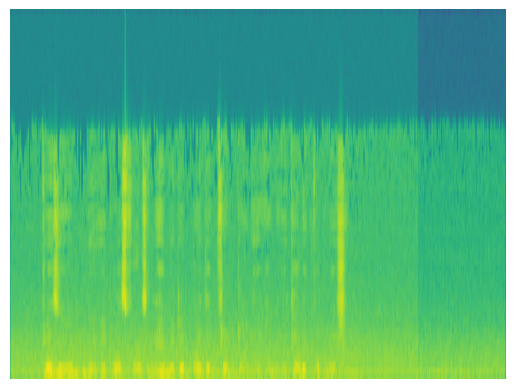

In [69]:
ds = ds.map(prepare_dataset, desc="preprocess dataset")

In [15]:
# split = ds.train_test_split(test_size = 0.2,train_size = 0.8)
# train = split['train']
# test = split['test']

x_train = ds["path"][:80]
y_train = ds["sentence"][:80]

x_test = ds["path"][:-20]
y_test = ds["sentence"][:-20]


In [9]:
#build model
model = keras.Sequential()
model.add(keras.layers.Dense(units = 128, activation = 'relu', input_shape = None))
model.add(keras.layers.Dense(units = 128, activation='relu'))
model.add(keras.layers.Dense(units = 128, activation ='relu'))
model.add(keras.layers.SimpleRNN(units = 128, activation = 'relu'))
model.add(keras.layers.Dense(29, activation = 'softmax'))
model.compile(optimizer='adam', metrics=['accuracy'])

2023-11-18 15:37:58.542654: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
#train model
#what you might have to do is iteratively run fit on all the audio samples
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size= 10)


Epoch 1/100


ValueError: in user code:

    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/hetricke/anaconda3/envs/speech_recog_env/lib/python3.11/site-packages/keras/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (10,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(10,), dtype=string)
      • training=True
      • mask=None


In [ ]:
#add computer i/o for speech recognition